# Load, Split, and Balance

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import logser
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('data.csv')

# drop rows with missing values
data = data.dropna()

#encode the string data as integers
label_encoder = LabelEncoder()
data['State'] = label_encoder.fit_transform(data['State'])
data['County'] = label_encoder.fit_transform(data['County'])

For now, we've decided to keep the county variable because by keeping the county variable, we could find patterns or trends specific to that county that would otherwise be lost if we removed the variable. However, since there are so many counties, it could make the model more complex and this could lead to overfitting. If it ends up causing overfitting, we'll consider removing it later.

### Balancing Dataset

We chose to use quantization thresholds for the ChildPoverty variable and divided them into 4 classes. By doing this, we ensure that each class has an approximately equal number of instances, which helps in balancing the dataset. Also, by using quantization thresholds we deal with the continuous variables by converting them into categorical variables, making them suitable for classification tasks.

We should only balance the training dataset because this ensures that model learns equally from all classes, preventing bias towards any particular class. We shouldn't balance the test dataset because it should  represent the real-world distribution of the data. Balancing the testing set would artificially alter the distribution of classes, leading to a bias in the model's performance.

In [45]:
from sklearn.model_selection import train_test_split

data['ChildPovertyClass'] = pd.qcut(data['ChildPoverty'], 4, labels=False)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['ChildPovertyClass'])

# Balance the training set
train_data = train_data.groupby('ChildPovertyClass').apply(lambda x: x.sample(train_data['ChildPovertyClass'].value_counts().min())).reset_index(drop=True)

/var/folders/c1/3wd_vs5n1wx3r37tqm98mpnw0000gn/T/ipykernel_2065/1201866809.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = train_data.groupby('ChildPovertyClass').apply(lambda x: x.sample(train_data['ChildPovertyClass'].value_counts().min())).reset_index(drop=True)


## MLP 

Epoch: 400/400

Accuracy: 0.2495874587458746


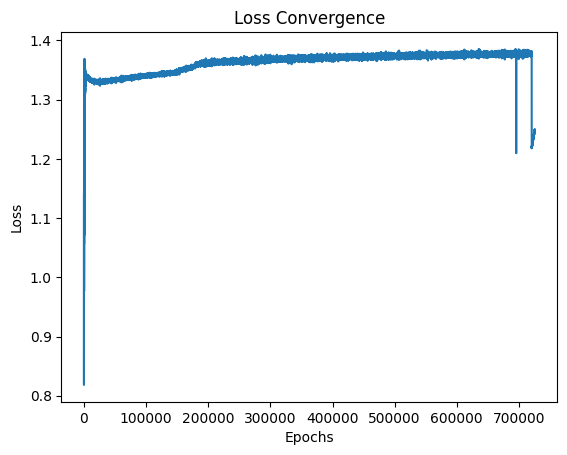

In [46]:
import numpy as np
from scipy.special import expit
import sys
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## this code is taken directly from the Github
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        

    def _initialize_weights(self):
        """Initialize weights with Glorot."""
        limit1 = np.sqrt(6 / (self.n_features_ + self.n_hidden))
        W1 = np.random.uniform(-limit1, limit1, (self.n_hidden, self.n_features_))
        b1 = np.zeros((self.n_hidden, 1))
        
        limit2 = np.sqrt(6 / (self.n_hidden + self.n_output_))
        W2 = np.random.uniform(-limit2, limit2, (self.n_output_, self.n_hidden))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2))
    
    def _cost(self,A3,Y,W1,W2):
        '''Get the objective function value'''
        m = y.shape[0]
        y_expanded = np.zeros_like(A3)
        y_expanded[y, np.arange(m)] = 1
        
        # Binary cross-entropy for each class prediction
        log_probs = -y_expanded * np.log(A3) - (1 - y_expanded) * np.log(1 - A3)
        cost = np.sum(log_probs) / m
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2).reshape(self.n_output_, -1)
        return A1, Z1, A2, Z2, A3
    
    def predict(self, X):
        """Predict class labels"""
        X = X.values
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0) if A3.shape[0] == self.n_output_ else np.argmax(A3.T, axis=1)
        return y_pred
    
    
 
            
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y, W1, W2):
        """ Compute gradient step using backpropagation.
        """

        m = Y.shape[0]
        Y_expanded = np.zeros_like(A3)
        Y_expanded[Y, np.arange(m)] = 1
        # vectorized backpropagation
        V2 = (A3 - Y_expanded) * A3 * (1 - A3)
        V1 = (W2.T @ V2) * A2 * (1 - A2)
        
        gradW2 = V2 @ A2.T / m
        gradW1 = V1 @ A1.T / m
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1)) / m
        gradb1 = np.sum(V1, axis=1).reshape((-1,1)) / m
        
        
        # regularize weights that are not bias terms
        gradW1 += self.l2_C * W1
        gradW2 += self.l2_C * W2
        return gradW1, gradW2, gradb1, gradb2
    
    def _initialize_weights(self):
        """Initialize weights with Glorot initialization."""
        limit1 = np.sqrt(6 / (self.n_features_ + self.n_hidden))
        self.W1 = np.random.uniform(-limit1, limit1, (self.n_hidden, self.n_features_))
        self.b1 = np.zeros((self.n_hidden, 1))
        
        limit2 = np.sqrt(6 / (self.n_hidden + self.n_output_))
        self.W2 = np.random.uniform(-limit2, limit2, (self.n_output_, self.n_hidden))
        self.b2 = np.zeros((self.n_output_, 1))
        return self.W1, self.W2, self.b1, self.b2
    
    def _cost(self, A3, y, W1, W2):
        """Cross-entropy loss without one-hot encoding."""
        m = y.shape[0]
        log_probs = -np.log(A3[y, np.arange(m)])
        cost = np.sum(log_probs) / m
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def fit(self, X, y, batch_size=32, print_progress=False):
        """Training without one-hot encoding"""
        X_data, y_data = X.values, y.values
        
        # Initialize weights
        self.n_features_ = X_data.shape[1]
        self.n_output_ = len(np.unique(y_data))  # Set output to number of classes
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        
        self.cost_ = []
        
        for i in range(self.epochs):
            indices = np.arange(X_data.shape[0])
            np.random.shuffle(indices)
            
            for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[batch_idx], self.W1, self.W2, self.b1, self.b2)
                
                cost = self._cost(A3, y_data[batch_idx], self.W1, self.W2)
                self.cost_.append(cost)
                
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                                    Y=y_data[batch_idx], W1=self.W1, W2=self.W2)
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
            
            if print_progress and (i + 1) % print_progress == 0:
                sys.stderr.write(f'\rEpoch: {i + 1}/{self.epochs}')
                sys.stderr.flush()
                
        return self

X_train = train_data.drop(columns=['ChildPovertyClass'])
y_train = train_data['ChildPovertyClass']
X_test = test_data.drop(columns=['ChildPovertyClass'])
y_test = test_data['ChildPovertyClass']

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptronVectorized(**params)

nn.fit(X_train, y_train, batch_size=32, print_progress=50)
yhat = nn.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy: {accuracy}')

plt.plot(nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.show()

    

# Normalized MLP


Epoch: 400/400

Accuracy: 0.24986248624862487


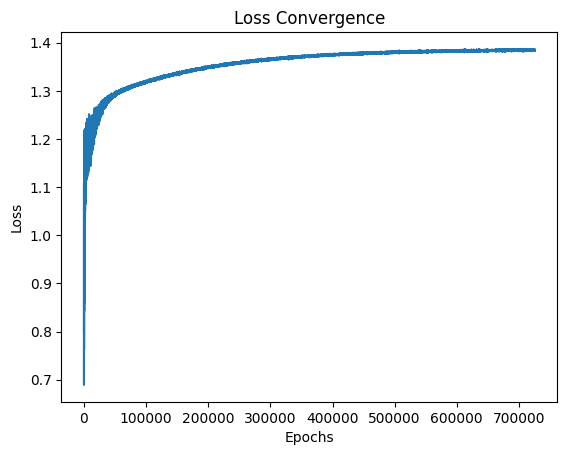

In [47]:
from sklearn.preprocessing import StandardScaler

numeric_features = train_data.select_dtypes(include=['float64', 'int']).columns

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(train_data[numeric_features])
X_test_normalized = scaler.transform(test_data[numeric_features])
X_train_normalized = pd.DataFrame(X_train_normalized, columns=numeric_features)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=numeric_features)

y_train = train_data['ChildPovertyClass']
y_test = test_data['ChildPovertyClass']

nn = TwoLayerPerceptronVectorized(**params)
nn.fit(X_train_normalized, y_train, batch_size=32, print_progress=50)

yhat = nn.predict(X_test_normalized)
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy: {accuracy}')

plt.plot(nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.show()


# Normalized + One Hot encoding

Epoch: 400/400

Accuracy: 0.24862486248624863


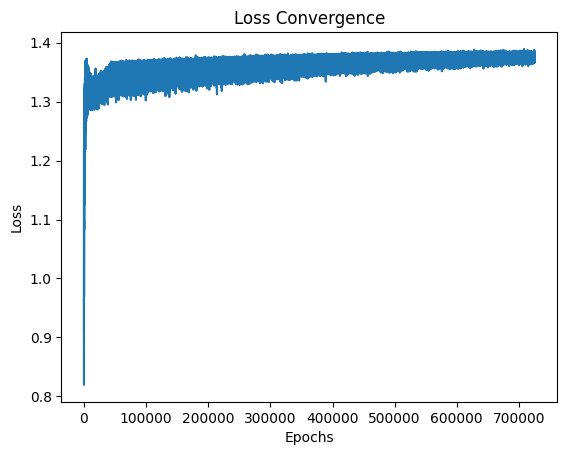

In [48]:
numeric_features = train_data.select_dtypes(include=['float64', 'int']).columns.difference(['State', 'County'])

scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(train_data[numeric_features])
X_test_numeric = scaler.transform(test_data[numeric_features])

X_train_categorical = pd.get_dummies(train_data[['State', 'County']])
X_test_categorical = pd.get_dummies(test_data[['State', 'County']])

X_train_categorical, X_test_categorical = X_train_categorical.align(X_test_categorical, join='left', axis=1, fill_value=0)

X_train_processed = pd.DataFrame(X_train_numeric, columns=numeric_features).join(X_train_categorical)
X_test_processed = pd.DataFrame(X_test_numeric, columns=numeric_features).join(X_test_categorical)


y_train = train_data['ChildPovertyClass']
y_test = test_data['ChildPovertyClass']

nn = TwoLayerPerceptronVectorized(**params)
nn.fit(X_train_processed, y_train, batch_size=32, print_progress=50)

yhat = nn.predict(X_test_processed)
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy: {accuracy}')

plt.plot(nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.show()


# Modeling

### Three Layer Perceptron

Epoch: 400/400

Accuracy: 0.24986248624862487


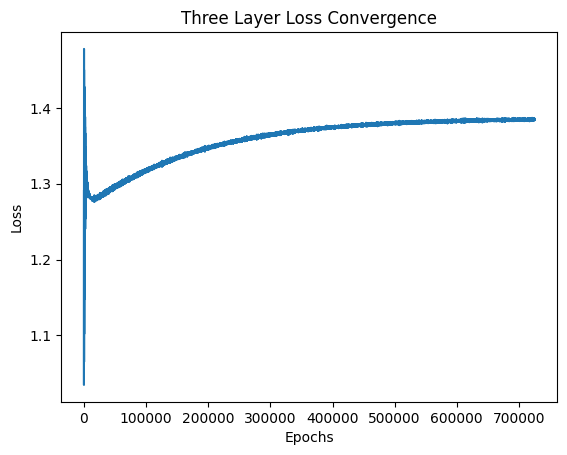

In [49]:
class ThreeLayerPerceptronBase(TwoLayerPerceptronBase):
    def __init__(self, n_hidden=30, n_hidden2=30, C=0.0, epochs=500, eta=0.001, random_state=None):
        super().__init__(n_hidden=n_hidden, C=C, epochs=epochs, eta=eta, random_state=random_state)
        self.n_hidden2 = n_hidden2

    def _initialize_weights(self):
        """Initialize weights for three layers."""
        limit1 = np.sqrt(6 / (self.n_features_ + self.n_hidden))
        W1 = np.random.uniform(-limit1, limit1, (self.n_hidden, self.n_features_))
        b1 = np.zeros((self.n_hidden, 1))
        
        limit2 = np.sqrt(6 / (self.n_hidden + self.n_hidden2))
        W2 = np.random.uniform(-limit2, limit2, (self.n_hidden2, self.n_hidden))
        b2 = np.zeros((self.n_hidden2, 1))

        limit3 = np.sqrt(6 / (self.n_hidden2 + self.n_output_))
        W3 = np.random.uniform(-limit3, limit3, (self.n_output_, self.n_hidden2))
        b3 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, b1, b2, b3
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost for three layers."""
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2) + np.mean(W3 ** 2))
    
    def _cost(self, A4, Y, W1, W2, W3):
        """Get the objective function value for three layers."""
        m = Y.shape[0]
        # Y_expanded = np.zeros_like(A4)
        # Y_expanded[Y, np.arange(m)] = 1
        # log_probs = -Y_expanded.log(A4) - (1 - Y_expanded) * np.log(1 - A4)
        log_probs = -np.log(A4[Y, np.arange(m)])
        cost = np.sum(log_probs) / m
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
class ThreeLayerPerceptron(ThreeLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step for three layers."""
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3).reshape(self.n_output_, -1)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def predict(self, X):
        """Predict class labels for three layers."""
        X = X.values
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0) if A4.shape[0] == self.n_output_ else np.argmax(A4.T, axis=1)
        return y_pred
    
class ThreeLayerPerceptronVectorized(ThreeLayerPerceptron):
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y, W1, W2, W3):
        """Compute gradient step using backpropagation for three layers."""
        m = Y.shape[0]
        Y_expanded = np.zeros_like(A4)
        Y_expanded[Y, np.arange(m)] = 1
        # vectorized backpropagation
        V3 = (A4 - Y_expanded) * A4 * (1 - A4)
        V2 = (W3.T @ V3) * A3 * (1 - A3)
        V1 = (W2.T @ V2) * A2 * (1 - A2)
        
        gradW3 = V3 @ A3.T / m
        gradW2 = V2 @ A2.T / m
        gradW1 = V1 @ A1.T / m
        
        gradb3 = np.sum(V3, axis=1).reshape((-1,1)) / m
        gradb2 = np.sum(V2, axis=1).reshape((-1,1)) / m
        gradb1 = np.sum(V1, axis=1).reshape((-1,1)) / m
        
        # regularize weights that are not bias terms
        gradW1 += self.l2_C * W1
        gradW2 += self.l2_C * W2
        gradW3 += self.l2_C * W3
        
        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def fit(self, X, y, batch_size=32, print_progress=False):
        """Training without one-hot encoding for three layers."""
        X_data, y_data = X.values, y.values
        
        # Initialize weights
        self.n_features_ = X_data.shape[1]
        self.n_output_ = len(np.unique(y_data))  # Set output to number of classes
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()
        
        self.cost_ = []
        self.grads_ = []
        
        for i in range(self.epochs):
            indices = np.arange(X_data.shape[0])
            np.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[batch_idx], self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
                
                cost = self._cost(A4, y_data[batch_idx], self.W1, self.W2, self.W3)
                self.cost_.append(cost)
                
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3,
                                                                                    Y=y_data[batch_idx], W1=self.W1, W2=self.W2, W3=self.W3)
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                
                grads = [
                    np.mean(np.abs(gradW1)), 
                    np.mean(np.abs(gradW2)),
                    np.mean(np.abs(gradW3))
                ]
                self.grads_.append(grads)
                
            if print_progress and (i + 1) % print_progress == 0:
                sys.stderr.write(f'\rEpoch: {i + 1}/{self.epochs}')
                sys.stderr.flush()
                    
        return self
    

X_train = train_data.drop(columns=['ChildPovertyClass'])
y_train = train_data['ChildPovertyClass']
X_test = test_data.drop(columns=['ChildPovertyClass'])
y_test = test_data['ChildPovertyClass']

params = dict(n_hidden=50, n_hidden2=50, C=0.1, epochs=400, eta=0.001, random_state=1)

nn_3 = ThreeLayerPerceptronVectorized(**params)

nn_3.fit(X_train, y_train, batch_size=32, print_progress=50)
yhat = nn_3.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy: {accuracy}')

plt.plot(nn_3.cost_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Three Layer Loss Convergence')
plt.show()

          

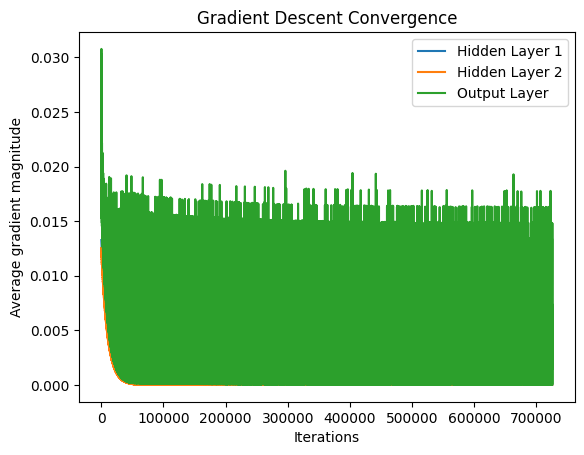

In [28]:
# average gradient magnitudes
grads = np.array(nn.grads_)
plt.plot(grads[:, 0], label='Hidden Layer 1')
plt.plot(grads[:, 1], label='Hidden Layer 2')
plt.plot(grads[:, 2], label='Output Layer')
plt.xlabel('Iterations')
plt.ylabel('Average gradient magnitude')
plt.legend()
plt.title('Gradient Descent Convergence')
plt.show()


### Four Layer Perceptron

Epoch: 400/400

Accuracy: 0.2495874587458746


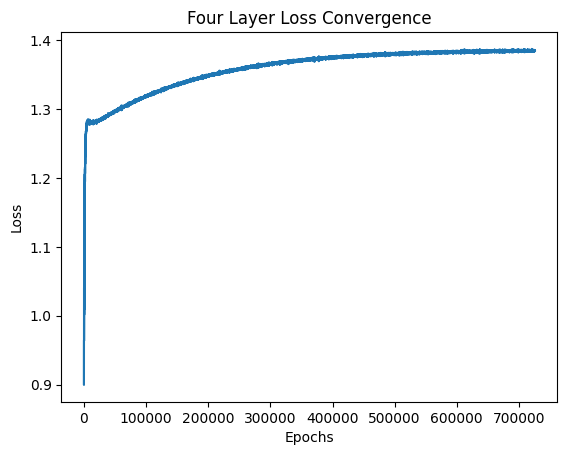

In [50]:
class FourLayerPerceptronBase(ThreeLayerPerceptronBase):
    def __init__(self, n_hidden=30, n_hidden2=30, n_hidden3=30, C=0.0, epochs=500, eta=0.001, random_state=None):
        super().__init__(n_hidden=n_hidden, n_hidden2=n_hidden2, C=C, epochs=epochs, eta=eta, random_state=random_state)
        self.n_hidden3 = n_hidden3

    def _initialize_weights(self):
        """Initialize weights for four layers."""
        limit1 = np.sqrt(6 / (self.n_features_ + self.n_hidden))
        W1 = np.random.uniform(-limit1, limit1, (self.n_hidden, self.n_features_))
        b1 = np.zeros((self.n_hidden, 1))
        
        limit2 = np.sqrt(6 / (self.n_hidden + self.n_hidden2))
        W2 = np.random.uniform(-limit2, limit2, (self.n_hidden2, self.n_hidden))
        b2 = np.zeros((self.n_hidden2, 1))

        limit3 = np.sqrt(6 / (self.n_hidden2 + self.n_hidden3))
        W3 = np.random.uniform(-limit3, limit3, (self.n_hidden3, self.n_hidden2))
        b3 = np.zeros((self.n_hidden3, 1))

        limit4 = np.sqrt(6 / (self.n_hidden3 + self.n_output_))
        W4 = np.random.uniform(-limit4, limit4, (self.n_output_, self.n_hidden3))
        b4 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, b1, b2, b3, b4
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost for four layers."""
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2) + np.mean(W3 ** 2) + np.mean(W4 ** 2))
    
    def _cost(self, A5, Y, W1, W2, W3, W4):
        """Get the objective function value for four layers."""
        m = Y.shape[0]
        log_probs = -np.log(A5[Y, np.arange(m)])
        cost = np.sum(log_probs) / m
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
class FourLayerPerceptron(FourLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        """Compute feedforward step for four layers."""
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4).reshape(self.n_output_, -1)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
    
    def predict(self, X):
        """Predict class labels for four layers."""
        X = X.values
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4)
        y_pred = np.argmax(A5, axis=0) if A5.shape[0] == self.n_output_ else np.argmax(A5.T, axis=1)
        return y_pred
    
        
class FourLayerPerceptronVectorized(FourLayerPerceptron):
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y, W1, W2, W3, W4):
        """Compute gradient step using backpropagation for four layers."""
        m = Y.shape[0]
        Y_expanded = np.zeros_like(A5)
        Y_expanded[Y, np.arange(m)] = 1
        # vectorized backpropagation
        V4 = (A5 - Y_expanded) * A5 * (1 - A5)
        V3 = (W4.T @ V4) * A4 * (1 - A4)
        V2 = (W3.T @ V3) * A3 * (1 - A3)
        V1 = (W2.T @ V2) * A2 * (1 - A2)
        
        gradW4 = V4 @ A4.T / m
        gradW3 = V3 @ A3.T / m
        gradW2 = V2 @ A2.T / m
        gradW1 = V1 @ A1.T / m
        
        gradb4 = np.sum(V4, axis=1).reshape((-1,1)) / m
        gradb3 = np.sum(V3, axis=1).reshape((-1,1)) / m
        gradb2 = np.sum(V2, axis=1).reshape((-1,1)) / m
        gradb1 = np.sum(V1, axis=1).reshape((-1,1)) / m
        
        # regularize weights that are not bias terms
        gradW1 += self.l2_C * W1
        gradW2 += self.l2_C * W2
        gradW3 += self.l2_C * W3
        gradW4 += self.l2_C * W4
        
        return gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4
    
    def fit (self, X, y, batch_size=32, print_progress=False):
        """Training without one-hot encoding for four layers."""
        X_data, y_data = X.values, y.values
        
        # Initialize weights
        self.n_features_ = X_data.shape[1]
        self.n_output_ = len(np.unique(y_data))
        self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4 = self._initialize_weights()
        
        self.cost_ = []
        self.grads_ = []
        
        for i in range(self.epochs):
            indices = np.arange(X_data.shape[0])
            np.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[batch_idx], self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4)
                
                cost = self._cost(A5, y_data[batch_idx], self.W1, self.W2, self.W3, self.W4)
                self.cost_.append(cost)
                
                gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4,
                                                                                                    Y=y_data[batch_idx], W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4)
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.W4 -= self.eta * gradW4
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4
                
                grads = [
                    np.mean(np.abs(gradW1)), 
                    np.mean(np.abs(gradW2)),
                    np.mean(np.abs(gradW3)),
                    np.mean(np.abs(gradW4))
                ]
                self.grads_.append(grads)
                
            if print_progress and (i + 1) % print_progress == 0:
                sys.stderr.write(f'\rEpoch: {i + 1}/{self.epochs}')
                sys.stderr.flush()
                        
        return self
        
X_train = train_data.drop(columns=['ChildPovertyClass'])
y_train = train_data['ChildPovertyClass']
X_test = test_data.drop(columns=['ChildPovertyClass'])
y_test = test_data['ChildPovertyClass']

params = dict(n_hidden=50, n_hidden2=50, n_hidden3=50, C=0.1, epochs=400, eta=0.001, random_state=1)
nn_4 = FourLayerPerceptronVectorized(**params)
nn_4.fit(X_train, y_train, batch_size=32, print_progress=50)
yhat = nn_4.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy: {accuracy}')
plt.plot(nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Four Layer Loss Convergence')
plt.show()   

### Five Layer Perceptron

Epoch: 400/400

Accuracy: 0.2495874587458746


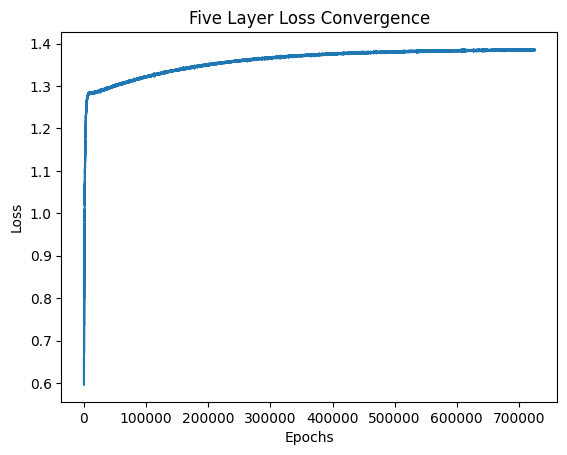

In [51]:
class FiveLayerPerceptronBase(FourLayerPerceptronBase):
    def __init__(self, n_hidden=30, n_hidden2=30, n_hidden3=30, n_hidden4=30, C=0.0, epochs=500, eta=0.001, random_state=None):
        super().__init__(n_hidden=n_hidden, n_hidden2=n_hidden2, n_hidden3=n_hidden3, C=C, epochs=epochs, eta=eta, random_state=random_state)
        self.n_hidden4 = n_hidden4

    def _initialize_weights(self):
        """Initialize weights for five layers."""
        limit1 = np.sqrt(6 / (self.n_features_ + self.n_hidden))
        W1 = np.random.uniform(-limit1, limit1, (self.n_hidden, self.n_features_))
        b1 = np.zeros((self.n_hidden, 1))
        
        limit2 = np.sqrt(6 / (self.n_hidden + self.n_hidden2))
        W2 = np.random.uniform(-limit2, limit2, (self.n_hidden2, self.n_hidden))
        b2 = np.zeros((self.n_hidden2, 1))

        limit3 = np.sqrt(6 / (self.n_hidden2 + self.n_hidden3))
        W3 = np.random.uniform(-limit3, limit3, (self.n_hidden3, self.n_hidden2))
        b3 = np.zeros((self.n_hidden3, 1))

        limit4 = np.sqrt(6 / (self.n_hidden3 + self.n_hidden4))
        W4 = np.random.uniform(-limit4, limit4, (self.n_hidden4, self.n_hidden3))
        b4 = np.zeros((self.n_hidden4, 1))

        limit5 = np.sqrt(6 / (self.n_hidden4 + self.n_output_))
        W5 = np.random.uniform(-limit5, limit5, (self.n_output_, self.n_hidden4))
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost for five layers."""
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2) + np.mean(W3 ** 2) + np.mean(W4 ** 2) + np.mean(W5 ** 2))
    
    def _cost(self, A6, Y, W1, W2, W3, W4, W5):
        """Get the objective function value for five layers."""
        m = Y.shape[0]
        log_probs = -np.log(A6[Y, np.arange(m)])
        cost = np.sum(log_probs) / m
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
class FiveLayerPerceptron(FiveLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        """Compute feedforward step for five layers."""
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5).reshape(self.n_output_, -1)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def predict(self, X):
        """Predict class labels for five layers."""
        X = X.values
        
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5)
        y_pred = np.argmax(A6, axis=0) if A6.shape[0] == self.n_output_ else np.argmax(A6.T, axis=1)
        return y_pred

class FiveLayerPerceptronVectorized(FiveLayerPerceptron):
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y, W1, W2, W3, W4, W5):
        """Compute gradient step using backpropagation for five layers."""
        m = Y.shape[0]
        Y_expanded = np.zeros_like(A6)
        Y_expanded[Y, np.arange(m)] = 1
        # vectorized backpropagation
        V5 = (A6 - Y_expanded) * A6 * (1 - A6)
        V4 = (W5.T @ V5) * A5 * (1 - A5)
        V3 = (W4.T @ V4) * A4 * (1 - A4)
        V2 = (W3.T @ V3) * A3 * (1 - A3)
        V1 = (W2.T @ V2) * A2 * (1 - A2)
        
        gradW5 = V5 @ A5.T / m
        gradW4 = V4 @ A4.T / m
        gradW3 = V3 @ A3.T / m
        gradW2 = V2 @ A2.T / m
        gradW1 = V1 @ A1.T / m
        
        gradb5 = np.sum(V5, axis=1).reshape((-1,1)) / m
        gradb4 = np.sum(V4, axis=1).reshape((-1,1)) / m
        gradb3 = np.sum(V3, axis=1).reshape((-1,1)) / m
        gradb2 = np.sum(V2, axis=1).reshape((-1,1)) / m
        gradb1 = np.sum(V1, axis=1).reshape((-1,1)) / m
        
        # regularize weights that are not bias terms
        gradW1 += self.l2_C * W1
        gradW2 += self.l2_C * W2
        gradW3 += self.l2_C * W3
        gradW4 += self.l2_C * W4
        gradW5 += self.l2_C * W5
        
        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5
    
    def fit(self, X, y, batch_size=32, print_progress=False):
        """Training without one-hot encoding for five layers."""
        X_data, y_data = X.values, y.values
        
        # Initialize weights
        self.n_features_ = X_data.shape[1]
        self.n_output_ = len(np.unique(y_data))
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()
        
        self.cost_ = []
        self.grads_ = []
        
        for i in range(self.epochs):
            indices = np.arange(X_data.shape[0])
            np.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[batch_idx], self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5)
                
                cost = self._cost(A6, y_data[batch_idx], self.W1, self.W2, self.W3, self.W4, self.W5)
                self.cost_.append(cost)
                
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                                                        Y=y_data[batch_idx], W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.W4 -= self.eta * gradW4
                self.W5 -= self.eta * gradW5
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4
                self.b5 -= self.eta * gradb5
                
                grads = [
                    np.mean(np.abs(gradW1)), 
                    np.mean(np.abs(gradW2)),
                    np.mean(np.abs(gradW3)),
                    np.mean(np.abs(gradW4)),
                    np.mean(np.abs(gradW5))
                ]
                self.grads_.append(grads)
                
            if print_progress and (i + 1) % print_progress == 0:
                sys.stderr.write(f'\rEpoch: {i + 1}/{self.epochs}')
                sys.stderr.flush()
                
        return self
    
X_train = train_data.drop(columns=['ChildPovertyClass'])
y_train = train_data['ChildPovertyClass']
X_test = test_data.drop(columns=['ChildPovertyClass'])
y_test = test_data['ChildPovertyClass']

params = dict(n_hidden=50, n_hidden2=50, n_hidden3=50, n_hidden4=50, C=0.1, epochs=400, eta=0.001, random_state=1)

nn_5 = FiveLayerPerceptronVectorized(**params)
nn_5.fit(X_train, y_train, batch_size=32, print_progress=50)
yhat = nn_5.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy: {accuracy}')

plt.plot(nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Five Layer Loss Convergence')
plt.show()
                